### Create a Time Series Model to predict the future air passenger traffic

In [1]:
## Importing librries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
## loading the data
data=pd.read_csv('AirPassengers.csv')
# we have data of airline passengers travelled between January 1949 and December 1960

In [3]:
data.head()#first five rows

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [4]:
data.tail()#last 5 rows

Month  #Passengers
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

In [5]:
data.info()#info about datatype and null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [6]:
# Month is actually given as string here. It must be in date-time format

In [7]:
## parse_dates: parsing the date (Converts the string representation of a date to Date object) 
# index_col: using date column as index

data=pd.read_csv('AirPassengers.csv',parse_dates=[0],index_col='Month')

# Basic checks

In [8]:
data.head()#first five rows


#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

In [9]:
data.rename(columns = {'#Passengers': 'Passengers'}, inplace = True)

In [10]:
data['Passengers']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, Length: 144, dtype: int64

In [11]:
data.describe()##used to view some basic statistical details like percentile, mean, std etc. 

Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000

# EDA

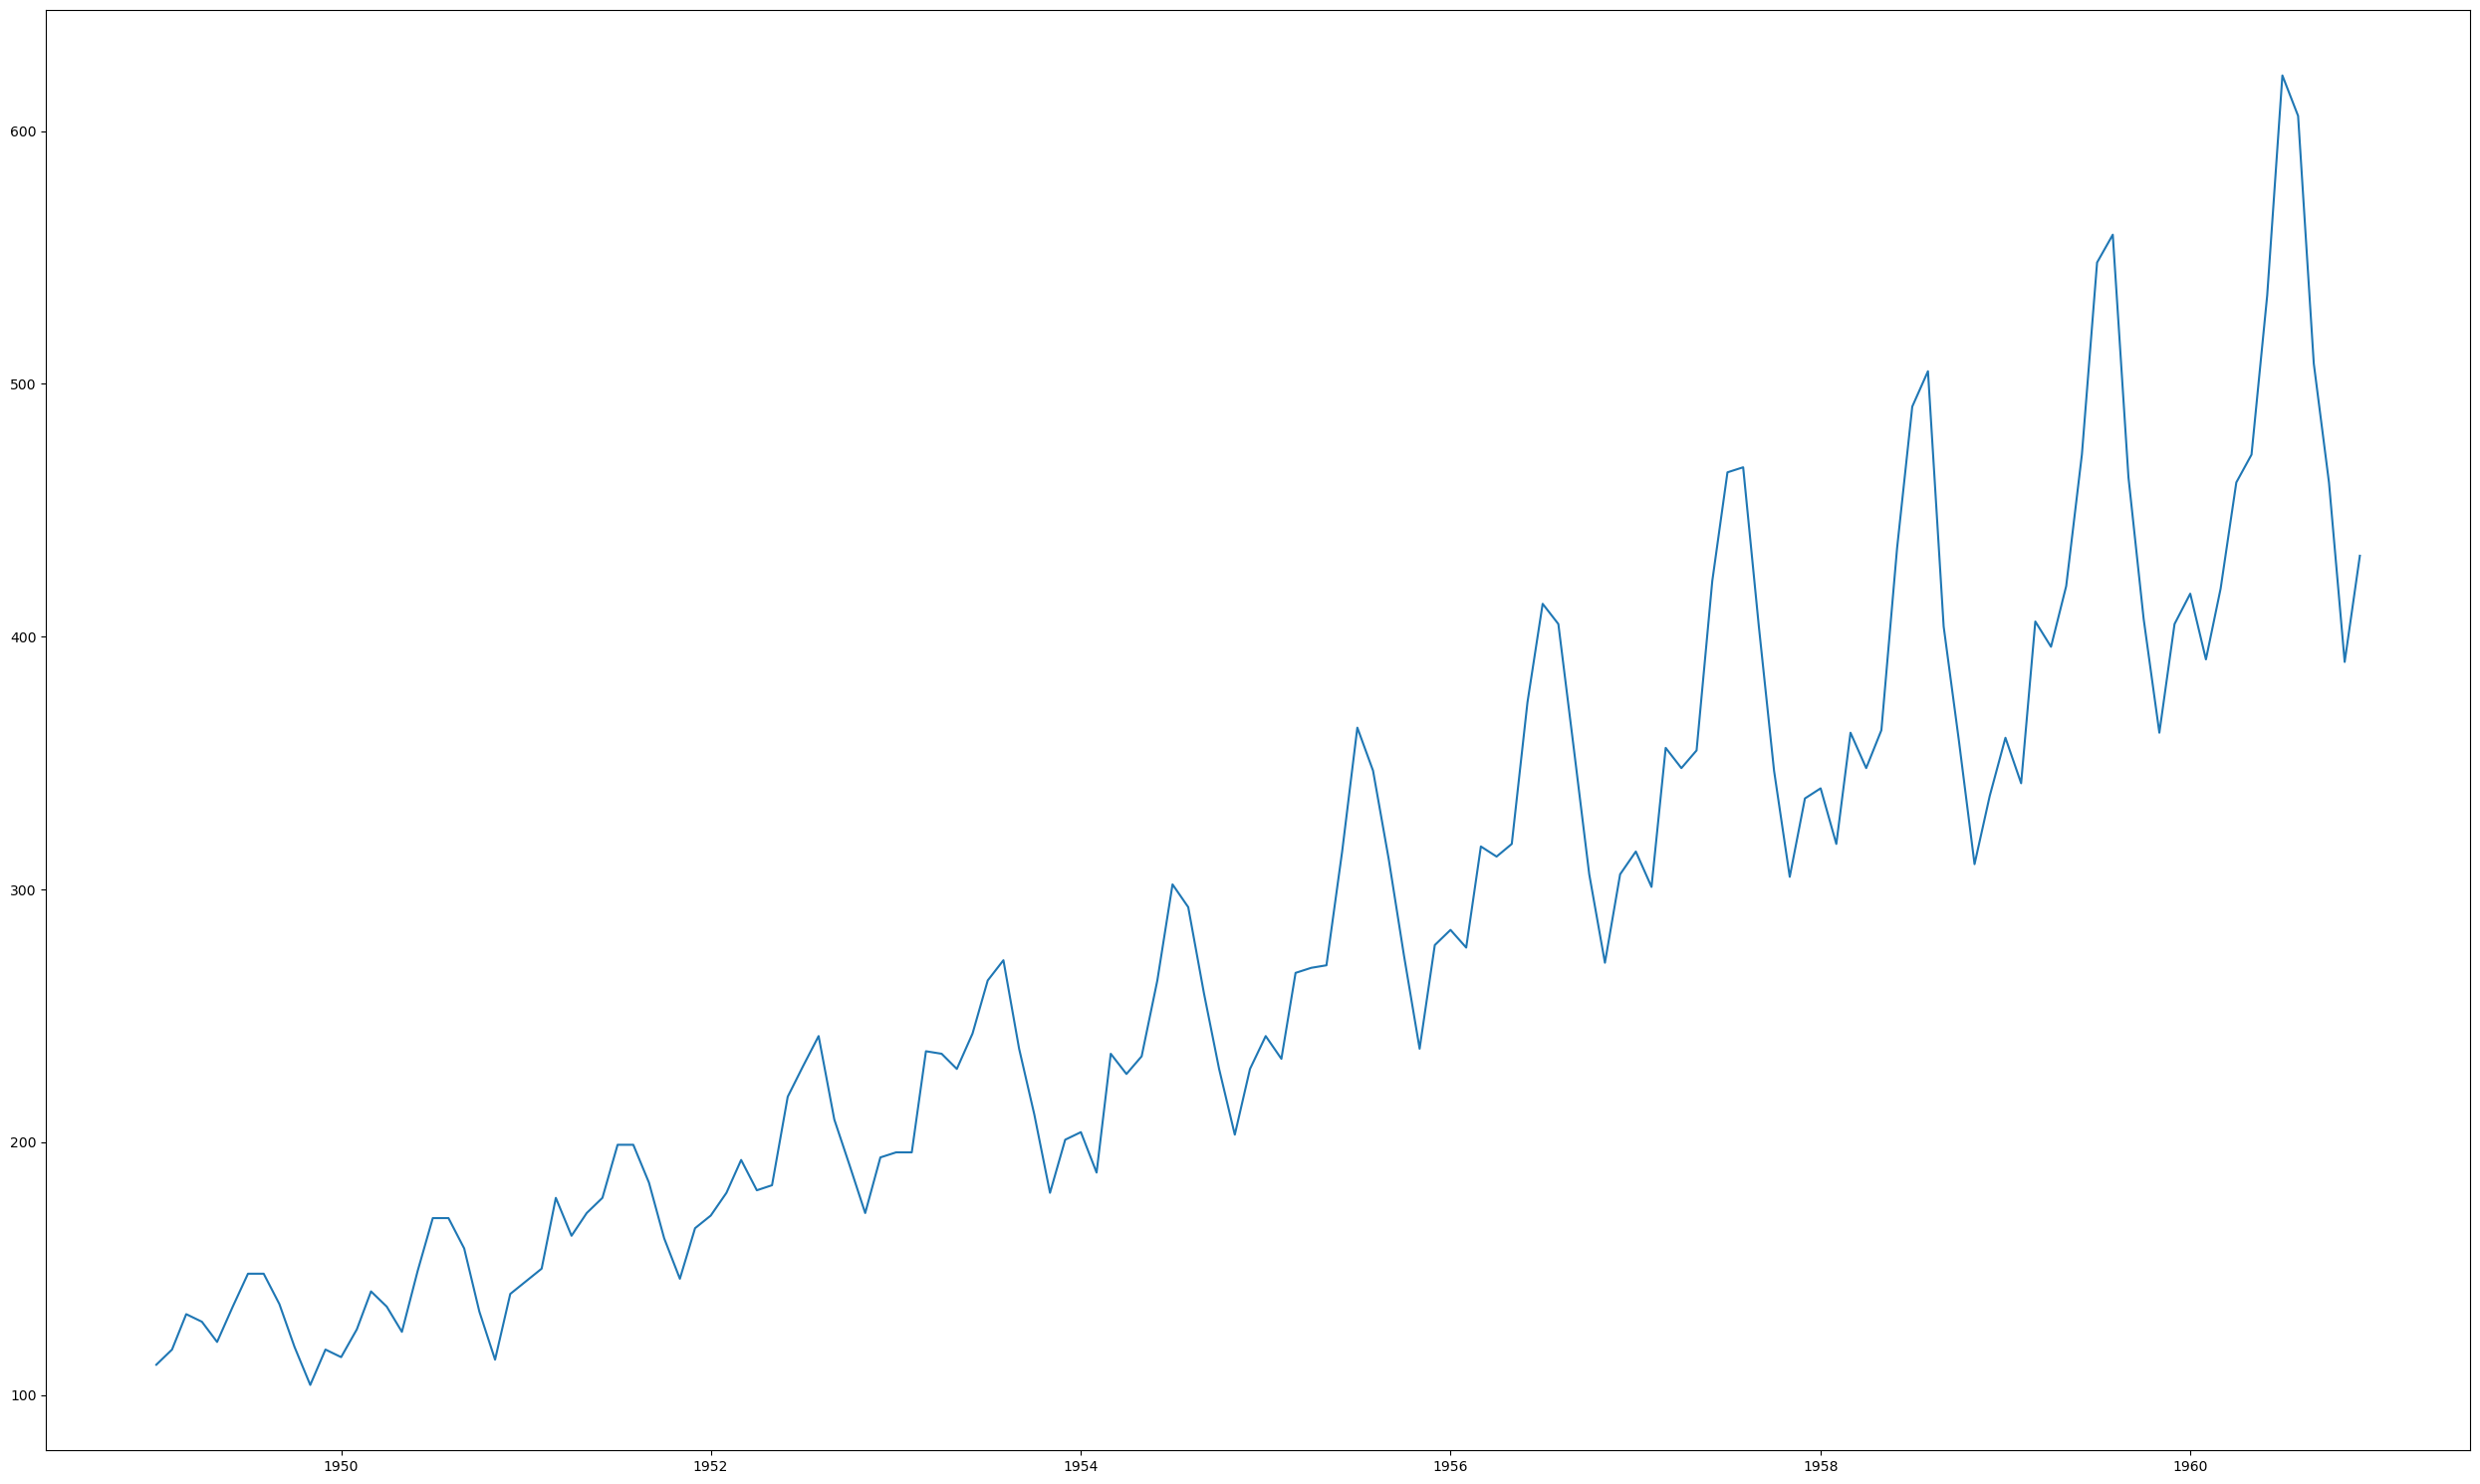

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15),facecolor='yellow')#canvas  size
plt.plot(data)#line plot 
plt.tight_layout()
## from plot we can see the series given is not stationary

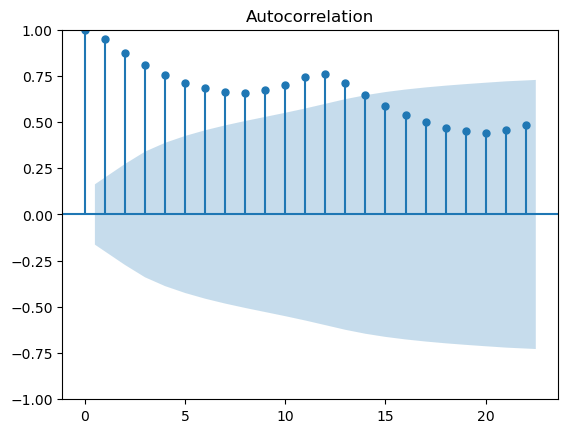

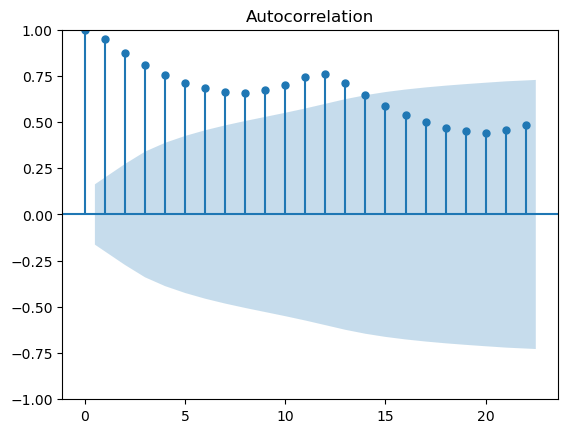

In [13]:
## Plotting the autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data)


In [14]:
# ADfuller Test to check stationarity 

from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data.Passengers, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  0.8153688792060597
2. P-Value :  0.9918802434376411
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 130
5. Critical Values :
	 1% :  -3.4816817173418295
	 5% :  -2.8840418343195267
	 10% :  -2.578770059171598


In [15]:
## making it stationary by taking difference of 1
data1=data.diff(periods=1) #This means calculating the change in your row(s)/column(s) over a set number of periods. Or simply, 
#pandas diff will subtract 1 cell value from another cell value within the same index.

In [16]:
data1 # Series integrated to the order of 1

Passengers
Month                 
1949-01-01         NaN
1949-02-01         6.0
1949-03-01        14.0
1949-04-01        -3.0
1949-05-01        -8.0
...                ...
1960-08-01       -16.0
1960-09-01       -98.0
1960-10-01       -47.0
1960-11-01       -71.0
1960-12-01        42.0

[144 rows x 1 columns]

In [17]:
data1=data1.iloc[1:] #null value discarded
data1

Passengers
Month                 
1949-02-01         6.0
1949-03-01        14.0
1949-04-01        -3.0
1949-05-01        -8.0
1949-06-01        14.0
...                ...
1960-08-01       -16.0
1960-09-01       -98.0
1960-10-01       -47.0
1960-11-01       -71.0
1960-12-01        42.0

[143 rows x 1 columns]

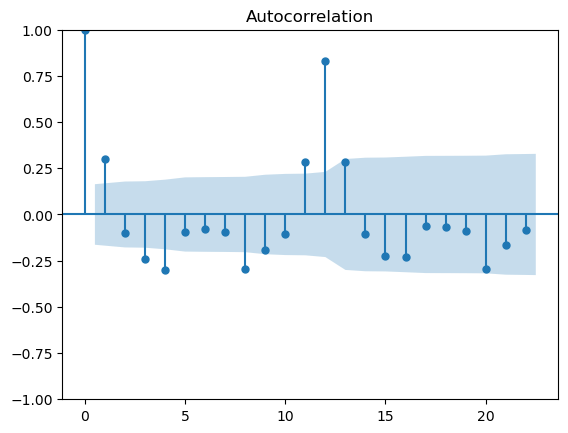

In [18]:
plot_acf(data1); # autocorrelation plot 

In [19]:
data2=data1.diff(periods=1) # differencing applied to data1

In [20]:
data2=data2.iloc[1:] # integrated to the order of 2

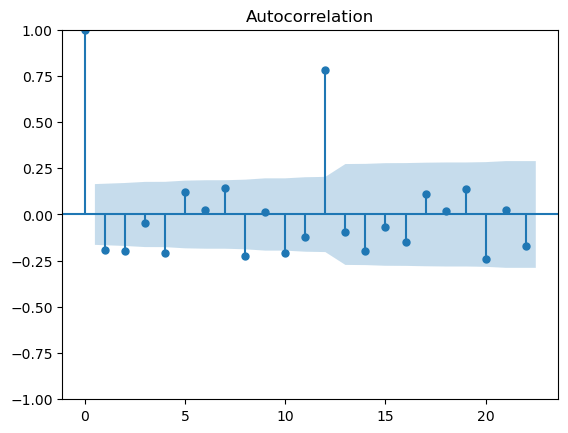

In [21]:
plot_acf(data2);

In [22]:
data2.shape#shape of the data rows and columns

(142, 1)

In [23]:
## Creating training and test sets
train=data2[:100] #from 0th row to 99th row - traning data
test=data2[100:] #from 100th row to end - testing data

In [24]:
train.info()#info about datatype and null value

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 1949-03-01 to 1957-06-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Passengers  100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


In [26]:
## Applying autoregressive model
#from statsmodels.tsa.ar_model import AR
##from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore')

In [27]:

#ar_select_order : gives the best lags ordered as an array

# to select the optimal values for lags
from statsmodels.tsa.ar_model import ar_select_order
mod = ar_select_order(data1,maxlag=15,glob=True)
mod.ar_lags

# select_order: selects the best number of lags
# maxlag: The maximum lag to consider
# glob: global search across all combinations of lags

[1, 8, 12, 13]

In [28]:
## model creation
ar_model=AutoReg(train,lags=[1,8,12,13]) ## object creation with lags specified
ar_model_fit=ar_model.fit() #training the model

In [29]:
##making prediction
prediction=ar_model_fit.predict(start=100,end=142)

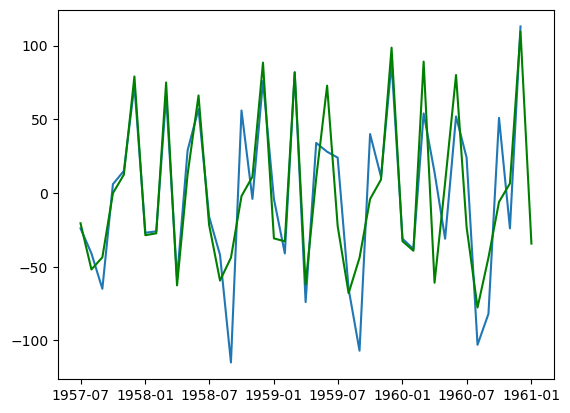

In [30]:
import matplotlib.pyplot as plt

plt.plot(test)
plt.plot(prediction,color='green') #graph of test vs prediction

## ARIMA Model

In [31]:
## importing the library
from statsmodels.tsa.arima.model import ARIMA

In [32]:
##Model object creation and fitting the model
model_arima = ARIMA(train, order=(1,1,0))#order= p,d,q

model_arima_fit = model_arima.fit()#training

In [33]:
## evaluate the model
print(model_arima_fit.aic)

1021.0396389673776


In [34]:
## predicting the output of sample points
predictions = model_arima_fit.forecast(steps=9)

In [35]:
predictions

1957-07-01    37.765356
1957-08-01    48.751565
1957-09-01    43.323244
1957-10-01    46.005395
1957-11-01    44.680135
1957-12-01    45.334950
1958-01-01    45.011404
1958-02-01    45.171269
1958-03-01    45.092279
Freq: MS, Name: predicted_mean, dtype: float64

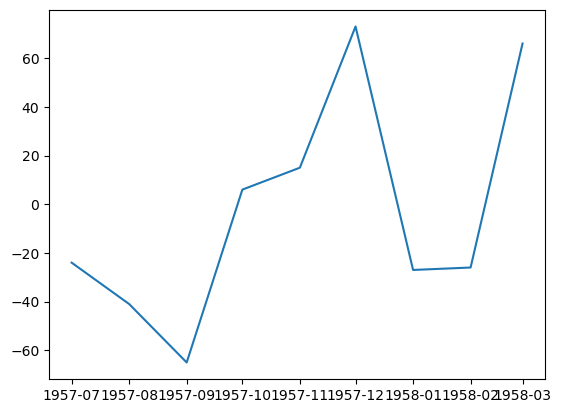

In [36]:
plt.plot(test[:9])

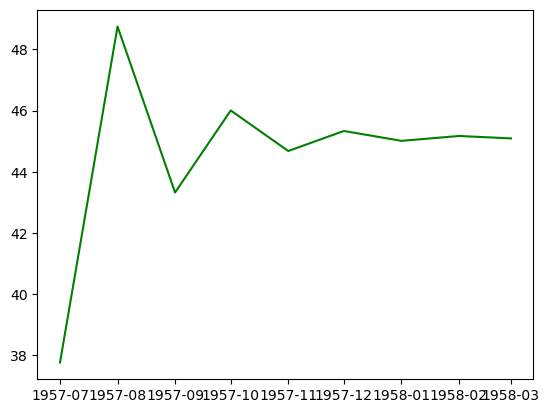

In [38]:
## plotting the ARIMA forecast values using random pdq
plt.plot(predictions,color='green')

In [39]:
## Geeting the optimal values of p,q an d
import itertools

p =d= q=range(0,5)#values of p,d,q range from 0 to 4

pdq = list(itertools.product(p,d,q))
# is used to find the cartesian product from the given iterator, output is lexicographic ordered.
pdq #number of combinaton of pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [40]:
##The Python try… except statement catches an exception. It is used to test code for an error which is written in the “try” statement.
#If an error is encountered, the contents of the “except” block are run.
list1=[]
list2=[]
for params in pdq: #iterating params over pdq
    try:
        model_arima = ARIMA(train, order=params)#training model on various pdq values
        model_arima_fit = model_arima.fit()#training
        print(params, model_arima_fit.aic)#printing parameter and aic values
        list1.append(params)
        list2.append(model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 967.9135518309452
(0, 0, 1) 931.437281104524
(0, 0, 2) 925.7296663864893
(0, 0, 3) 920.9009365266666
(0, 0, 4) 912.6569512615787
(0, 1, 0) 1046.7319001420174
(0, 1, 1) 963.8739387623483
(0, 1, 2) 933.2130365323442
(0, 1, 3) 926.5735460079998
(0, 1, 4) 924.311365955854
(0, 2, 0) 1143.9983209811053
(0, 2, 1) 1043.7570583844451
(0, 2, 2) 966.1633952995417
(0, 2, 3) 941.6116039858562
(0, 2, 4) 933.756401250724
(0, 3, 0) 1247.2070979580242
(0, 3, 1) 1139.8659459337032
(0, 3, 2) 1044.6471605054996
(0, 3, 3) 972.366041514582
(0, 3, 4) 955.3691169611801
(0, 4, 0) 1351.0676098839504
(0, 4, 1) 1241.6050826097264
(0, 4, 2) 1139.2023602413446
(0, 4, 3) 1048.6628819450657
(0, 4, 4) 987.1564143046871
(1, 0, 0) 963.0127961447531
(1, 0, 1) 928.7077562630661
(1, 0, 2) 919.8685371067342
(1, 0, 3) 921.8388138771824
(1, 0, 4) 923.3886062554853
(1, 1, 0) 1021.0396389673776
(1, 1, 1) 959.4979676508102
(1, 1, 2) 962.9514176508055
(1, 1, 3) 923.2264337249069
(1, 1, 4) 923.1013932274815
(1, 2, 0) 109

In [41]:
min(list2)  # lowest aic score

904.9117972136689

In [42]:
# pdq corresponding to lowest aic
loc=list2.index(min(list2))
list1[loc]

(4, 0, 3)

In [43]:
## create the final model with lowest aic score parameter
model_arima = ARIMA(train, order=(4, 0, 3))

model_arima_fit = model_arima.fit() #training

In [44]:
print(model_arima_fit.aic) # confirm aic score

904.9117972136689


In [45]:
forecast = model_arima_fit.forecast(steps=9)
forecast 

1957-07-01   -51.877937
1957-08-01   -22.750884
1957-09-01    22.964179
1957-10-01   -22.793630
1957-11-01     5.529112
1957-12-01    28.124647
1958-01-01   -28.701403
1958-02-01    -0.724893
1958-03-01    26.553457
Freq: MS, Name: predicted_mean, dtype: float64

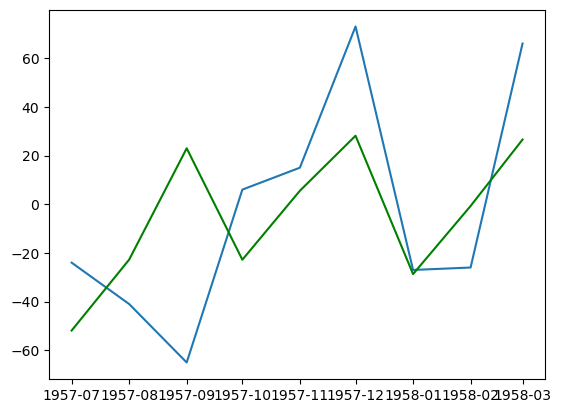

In [46]:
# Comparision of actual vs predicted for 9 values
plt.plot(test[:9])
plt.plot(forecast,color='green')#line plot for prediction

In [47]:
forecast25 = model_arima_fit.forecast(steps=25)
test1 = test[0:25].values.flatten()
test1

array([ -24.,  -41.,  -65.,    6.,   15.,   73.,  -27.,  -26.,   66.,
        -58.,   29.,   57.,  -16.,  -42., -115.,   56.,   -4.,   76.,
         -4.,  -41.,   82.,  -74.,   34.,   28.,   24.])

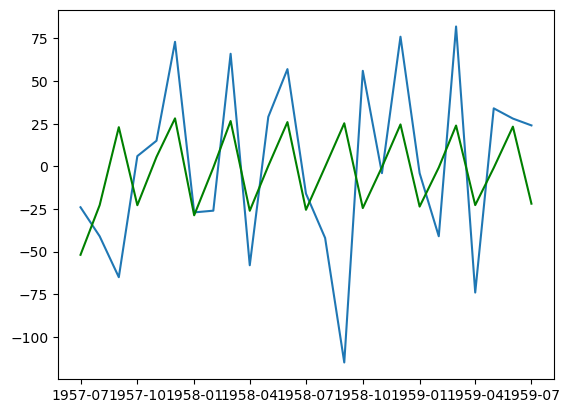

In [48]:
# Comparision of actual vs predicted for 25 values
plt.plot(test[:25])
plt.plot(forecast25,color='green') #line plot for prediction

In [49]:
# Accuracy metrics
import numpy as np
def forecast_accuracy(forecast, actual):
    mse = np.mean((forecast - actual)**2)        # MSE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
 
    return({'mse':mse, 'mae': mae, 'rmse':rmse})

forecast_accuracy(forecast25, test1)

{'mse': 2351.366204171978, 'mae': 38.28571938179, 'rmse': 48.49088784681074}

In [50]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
print(rmse(test1, forecast25))
  
# Calculate mean squared error
mean_squared_error(test1, forecast25)


48.49088784681074


2351.366204171978